In [1]:
%matplotlib notebook
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

import matplotlib.pyplot as plt
import matplotlib



from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
sns.set()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cpu


## Load data from files

In [3]:
#Path to data
train_path = 'Data/data_train.npz'
test_path = 'Data/data_test.npz'

In [4]:
train_data = np.load(train_path, allow_pickle=True)
test_data = np.load(test_path, allow_pickle=True)

In [5]:
ClusterN_train = train_data['ClusterN']
Cluster_train = train_data['Cluster']
ClusterType_train = train_data['ClusterType']
ClusterE_train = train_data['ClusterE']
ClusterPt_train = train_data['ClusterPt']
ClusterModuleNumber_train = train_data['ClusterModuleNumber']
ClusterCol_train = train_data['ClusterCol']
ClusterRow_train = train_data['ClusterRow']
ClusterM02_train = train_data['ClusterM02']
ClusterM20_train = train_data['ClusterM20']
PartE_train = train_data['PartE']
PartPt_train = train_data['PartPt']
PartEta_train = train_data['PartEta']
PartPhi_train = train_data['PartPhi']
PartIsPrimary_train = train_data['PartIsPrimary']
PartPID_train = train_data['PartPID']

In [6]:
ClusterN_test = test_data['ClusterN']
Cluster_test = test_data['Cluster']
ClusterType_test = test_data['ClusterType']
ClusterE_test = test_data['ClusterE']
ClusterPt_test = test_data['ClusterPt']
ClusterModuleNumber_test = test_data['ClusterModuleNumber']
ClusterCol_test = test_data['ClusterCol']
ClusterRow_test = test_data['ClusterRow']
ClusterM02_test = test_data['ClusterM02']
ClusterM20_test = test_data['ClusterM20']
PartE_test = test_data['PartE']
PartPt_test = test_data['PartPt']
PartEta_test = test_data['PartEta']
PartPhi_test = test_data['PartPhi']
PartIsPrimary_test = test_data['PartIsPrimary']
PartPID_test = test_data['PartPID']

## Temporary change for PID into three categories

In [7]:
def change_pid(arr):
    arr[np.nonzero((arr != 111) & (arr != 221))] = 0
    arr[arr == 111] = 1
    arr[arr == 221] = 2

In [8]:
change_pid(PartPID_test)
change_pid(PartPID_train)

## Reshape the arrays into [size, 1] for usage with ptorch

For linear layers input is expected as [batch_size, num_features] so no need to reshape the existing arrays like Cluster

reconstrcuted clusters later will have to have dim [batch_size, channel, height, width] as input for conv2d-layers

In [10]:
maxClusN_train = np.max(ClusterN_train)
maxClusN_test = np.max(ClusterN_test)
maxClusN = np.max([maxClusN_test, maxClusN_train])

In [11]:
ClusterN_train = ClusterN_train.reshape((ClusterN_train.size, 1))
#Cluster_train = Cluster_train.reshape((ClusterE_train.size, maxClusN))
ClusterType_train = ClusterType_train.reshape((ClusterType_train.size, 1))
ClusterE_train = ClusterE_train.reshape((ClusterE_train.size, 1))
ClusterPt_train = ClusterPt_train.reshape((ClusterPt_train.size, 1))
#ClusterModuleNumber_train = ClusterModuleNumber_train.reshape((ClusterModuleNumber_train.size, maxClusN))
#ClusterRow_train = ClusterRow_train.reshape((ClusterRow_train.size, maxClusN))
#ClusterCol_train = ClusterCol_train.reshape((ClusterCol_train.size, maxClusN))
ClusterM02_train = ClusterM02_train.reshape((ClusterM02_train.size, 1))
ClusterM20_train = ClusterM20_train.reshape((ClusterM20_train.size, 1))
PartE_train = PartE_train.reshape((PartE_train.size, 1))
PartPt_train = PartPt_train.reshape((PartPt_train.size, 1))
PartEta_train = PartEta_train.reshape((PartEta_train.size, 1))
PartPhi_train = PartPhi_train.reshape((PartPhi_train.size, 1))
PartIsPrimary_train = PartIsPrimary_train.reshape((PartIsPrimary_train.size, 1))
PartPID_train = PartPID_train.reshape((PartPID_train.size, 1))

In [12]:
ClusterN_test = ClusterN_test.reshape((ClusterN_test.size, 1))
#Cluster_test = Cluster_test.reshape((ClusterE_test.size, maxClusN))
ClusterType_test = ClusterType_test.reshape((ClusterType_test.size, 1))
ClusterE_test = ClusterE_test.reshape((ClusterE_test.size, 1))
ClusterPt_test = ClusterPt_test.reshape((ClusterPt_test.size, 1))
#ClusterModuleNumber_test = ClusterModuleNumber_test.reshape((ClusterModuleNumber_test.size, maxClusN))
#ClusterRow_test = ClusterRow_test.reshape((ClusterRow_test.size, maxClusN))
#ClusterCol_test = ClusterCol_test.reshape((ClusterCol_test.size, maxClusN))
ClusterM02_test = ClusterM02_test.reshape((ClusterM02_test.size, 1))
ClusterM20_test = ClusterM20_test.reshape((ClusterM20_test.size, 1))
PartE_test = PartE_test.reshape((PartE_test.size, 1))
PartPt_test = PartPt_test.reshape((PartPt_test.size, 1))
PartEta_test = PartEta_test.reshape((PartEta_test.size, 1))
PartPhi_test = PartPhi_test.reshape((PartPhi_test.size, 1))
PartIsPrimary_test = PartIsPrimary_test.reshape((PartIsPrimary_test.size, 1))
PartPID_test = PartPID_test.reshape((PartPID_test.size, 1))

## Load it to pytorch `tensor`

In [14]:
ClusterN_train = torch.as_tensor(ClusterN_train, dtype=torch.uint8)
Cluster_train = torch.as_tensor(Cluster_train, dtype=torch.float32)
ClusterType_train = torch.as_tensor(ClusterType_train, dtype=torch.uint8)
ClusterE_train = torch.as_tensor(ClusterE_train, dtype=torch.float32)
ClusterPt_train = torch.as_tensor(ClusterPt_train, dtype=torch.float32)
ClusterModuleNumber_train = torch.as_tensor(ClusterModuleNumber_train, dtype=torch.uint8)
ClusterRow_train = torch.as_tensor(ClusterRow_train, dtype=torch.uint8)
ClusterCol_train = torch.as_tensor(ClusterCol_train, dtype=torch.uint8)
ClusterM02_train = torch.as_tensor(ClusterM02_train, dtype=torch.float32)
ClusterM20_train = torch.as_tensor(ClusterM20_train, dtype=torch.float32)
PartE_train = torch.as_tensor(PartE_train, dtype=torch.float32)
PartPt_train = torch.as_tensor(PartPt_train, dtype=torch.float32)
PartEta_train = torch.as_tensor(PartEta_train, dtype=torch.float32)
PartPhi_train = torch.as_tensor(PartPhi_train, dtype=torch.float32)
PartIsPrimary_train = torch.as_tensor(PartIsPrimary_train, dtype=torch.bool)
PartPID_train = torch.as_tensor(PartPID_train, dtype=torch.short)

In [16]:
ClusterN_test = torch.as_tensor(ClusterN_test, dtype=torch.uint8)
Cluster_test = torch.as_tensor(Cluster_test, dtype=torch.float32)
ClusterType_test = torch.as_tensor(ClusterType_test, dtype=torch.uint8)
ClusterE_test = torch.as_tensor(ClusterE_test, dtype=torch.float32)
ClusterPt_test = torch.as_tensor(ClusterPt_test, dtype=torch.float32)
ClusterModuleNumber_test = torch.as_tensor(ClusterModuleNumber_test, dtype=torch.uint8)
ClusterRow_test = torch.as_tensor(ClusterRow_test, dtype=torch.uint8)
ClusterCol_test = torch.as_tensor(ClusterCol_test, dtype=torch.uint8)
ClusterM02_test = torch.as_tensor(ClusterM02_test, dtype=torch.float32)
ClusterM20_test = torch.as_tensor(ClusterM20_test, dtype=torch.float32)
PartE_test = torch.as_tensor(PartE_test, dtype=torch.float32)
PartPt_test = torch.as_tensor(PartPt_test, dtype=torch.float32)
PartEta_test = torch.as_tensor(PartEta_test, dtype=torch.float32)
PartPhi_test = torch.as_tensor(PartPhi_test, dtype=torch.float32)
PartIsPrimary_test = torch.as_tensor(PartIsPrimary_test, dtype=torch.bool)
PartPID_test = torch.as_tensor(PartPID_test, dtype=torch.short)

## Load it to pytorch `DataLoader`

In [18]:
dataset_train = utils.TensorDataset( ClusterN_train, Cluster_train, ClusterType_train, ClusterE_train
                                    , ClusterPt_train
                                    , ClusterModuleNumber_train, ClusterRow_train, ClusterCol_train
                                    , ClusterM02_train, ClusterM20_train, PartE_train, PartPt_train
                                    , PartEta_train, PartPhi_train, PartIsPrimary_train, PartPID_train )

In [19]:
dataset_test = utils.TensorDataset( ClusterN_test, Cluster_test, ClusterType_test, ClusterE_test, ClusterPt_test
                                    , ClusterModuleNumber_test, ClusterRow_test, ClusterCol_test
                                    , ClusterM02_test, ClusterM20_test, PartE_test, PartPt_test
                                    , PartEta_test, PartPhi_test, PartIsPrimary_test, PartPID_test )

In [29]:
def get_data(train_ds, test_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(test_ds, batch_size=bs * 2),
    )

In [20]:
#dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

In [28]:
#dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128)

## Instance Noise

In [22]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = False

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Define the network

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(10,10, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(10,10, kernel_size=5, padding=0)
        self.conv4 = nn.Conv2d(10,5, kernel_size=3, padding=0)
        self.conv5 = nn.Conv2d(5,3, kernel_size=1)
        self.flatten = nn.Flatten()
        self.dense_nn = nn.Sequential(
            nn.Linear(3615, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,3),
            nn.ReLU()
        )
        
    def forward(self, cluster, clusNumXYEPt):
        cluster = F.relu(self.conv1(cluster))
        cluster = F.relu(self.conv2(cluster))
        cluster = F.relu(self.conv3(cluster))
        x = self.flatten(cluster)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [24]:
device = 'cpu'

In [25]:
model = CNN().to(device)

In [26]:
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(5, 3, kernel_size=(1, 1), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_nn): Sequential(
    (0): Linear(in_features=3615, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=3, bias=True)
    (11): ReLU()
  )
)


## Set loss function and dataloader

In [27]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop
[0: 'ClusterN', 1:'Cluster', 2:'ClusterType', 3:'ClusterE', 4:'ClusterPt', 5:'ClusterModuleNumber', 6:'ClusterX', 7:'ClusterY', 8:'ClusterM02', 9:'ClusterM20', 10:'PartE', 11:'PartPt', 12:'PartEta', 13:'PartPhi', 14:'PartIsPrimary', 15:'PartPID']

In [ ]:
def reconstruct_cluster(ncell, modnum, row, col, data, arrsize=20):
    if not np.all( modnum[0] == modnum[:ncell]):
        ModNumDif = modnum - np.min(modnum[:ncell])
        mask = np.where(ModNumDif == 1)
        col[mask] += 48
        mask = np.where(ModNumDif == 2)
        row[mask] += 24
        mask = np.where(ModNumDif == 3)
        row[mask] += 24
        col[mask] += 48

    arr = np.zeros((arrsize,arrsize))
        
    col_min = np.min(col[:ncell])
    row_min = np.min(row[:ncell])
    width = np.max(col) - col_min
    height = np.max(row) - row_min
    offset_h = int((arrsize-height)/2)
    offset_w = int((arrsize-width)/2)
        
        
    for i in range(ncell):
        arr[ row[i] - row_min + offset_h, col[i] - col_min + offset_w ] = data[i]
   
    return arr

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        ClN, Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0], data[1],\
        data[3].float().to(device), data[4].float().to(device), data[5], \
        data[6], data[7], data[15].float().to(device)
        
        ClusterProperties = torch.cat([ClE, ClPt, ClModNum, ClX, ClY], dim=1)
        
        if INSTANCE_NOISE:
            Cl = add_instance_noise(Cl)
        
        #prediction and loss
        pred = model(Cl, ClusterProperties)
        loss = loss_fn(pred, PartPID[:,0].long())
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(ClE)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [26]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for data in dataloader:
            ClN, Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0], data[1],\
            data[3].float().to(device), data[4].float().to(device), data[5], \
            data[6], data[7], data[15].float().to(device)
            
            ClusterProperties = torch.cat([ClE, ClPt, ClModNum, ClX, ClY], dim=1)
            
            if INSTANCE_NOISE:
                Cl = add_instance_noise(Cl)
            
            pred = model(Cl, ClusterProperties)
            test_loss += loss_fn(pred, PartPID[:,0].long()).item()
            correct += (pred.argmax(1) == PartPID[:,0]).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [27]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


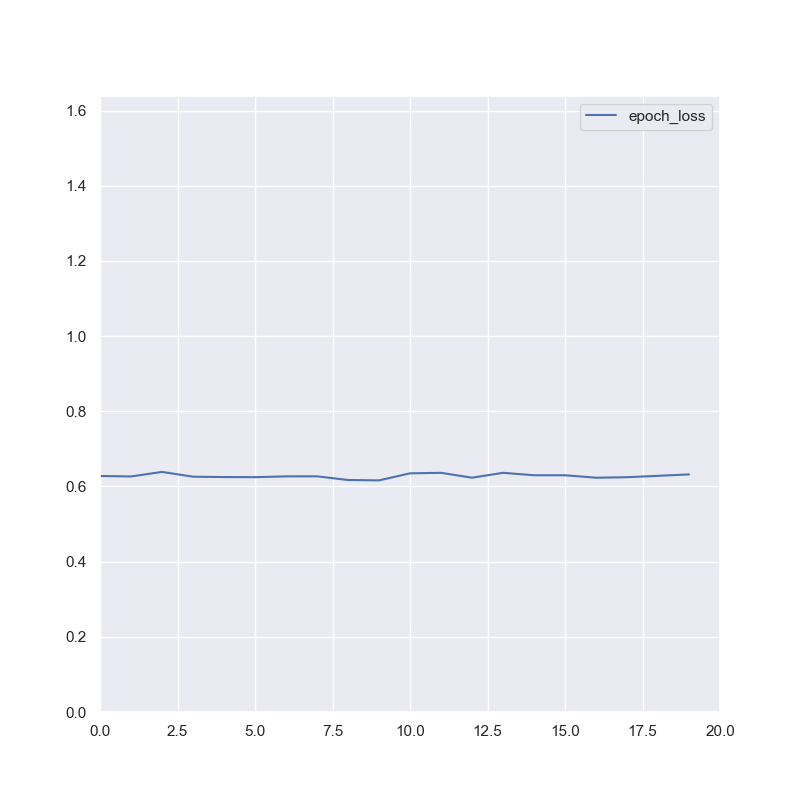

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.099051 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.627818 

Epoch 2
-------------------------------
loss: 0.511134 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.626556 

Epoch 3
-------------------------------
loss: 0.522535 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.638660 

Epoch 4
-------------------------------
loss: 0.600614 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.625945 

Epoch 5
-------------------------------
loss: 0.572255 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.624978 

Epoch 6
-------------------------------
loss: 0.578565 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.624685 

Epoch 7
-------------------------------
loss: 0.685767 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.626804 

Epoch 8
-------------------------------
loss: 0.575395 [    0/11386]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.626962 

Epoch 9
------------------------

In [28]:
plt.ion()
run_training(20)